In [34]:
import os
import numpy as np
import glob
import PIL.Image as Image

# pip install torchsummary
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.datasets as datasets
from torch.utils.data import DataLoader
import torchvision.transforms as transforms
from torchvision import models
from torchsummary import summary
import torch.optim as optim
from time import time

import matplotlib.pyplot as plt
from IPython.display import clear_output

class DRIVEDataLoader(torch.utils.data.Dataset):
    def __init__(self, train=True, transform=None, data_path='/dtu/datasets1/02516/DRIVE'):
        'Initialization'
        self.transform = transform
        self.is_train_loader = train
        if train:
            # Training data
            image_folder = os.path.join(data_path, 'training', 'images')
            vessel_mask_folder = os.path.join(data_path, 'training', '1st_manual')  # Vessel masks for training
            fov_mask_folder = os.path.join(data_path, 'training', 'mask')  # Field of view masks for training
        else:
            # Test data
            image_folder = os.path.join(data_path, 'test', 'images')
            fov_mask_folder = os.path.join(data_path, 'test', 'mask')  # Only FOV masks are available for test set
            vessel_mask_folder = None  # No vessel mask for test set

        # Get image paths
        self.image_paths = sorted(glob.glob(os.path.join(image_folder, '*.tif')))

        # Get vessel mask paths if available (for training)
        if vessel_mask_folder:
            self.vessel_mask_paths = sorted(glob.glob(os.path.join(vessel_mask_folder, '*.gif')))
        else:
            self.vessel_mask_paths = [None] * len(self.image_paths)  # No vessel mask for test set

        # Get FOV mask paths
        self.fov_mask_paths = sorted(glob.glob(os.path.join(fov_mask_folder, '*.gif')))
        
        # Check if we have found the files
        if len(self.image_paths) == 0 or len(self.fov_mask_paths) == 0:
            raise ValueError(f"No images or masks found in the provided path: {data_path}")

        if train and len(self.image_paths) != len(self.vessel_mask_paths):
            raise ValueError("Mismatch between the number of images and vessel masks in the training set.")

    def __len__(self):
        'Returns the total number of samples'
        return len(self.image_paths)

    def __getitem__(self, idx):
        'Generates one sample of data'
        image_path = self.image_paths[idx]
        vessel_mask_path = self.vessel_mask_paths[idx]
        fov_mask_path = self.fov_mask_paths[idx]

        # Load the image
        image = Image.open(image_path)

        # Load the vessel mask (if available, i.e., for training)
        vessel_mask = Image.open(vessel_mask_path) if vessel_mask_path else None

        # Load the FOV mask
        fov_mask = Image.open(fov_mask_path)

        # Apply transforms to the image and masks
        if self.transform:
            image = self.transform(image)
            fov_mask = self.transform(fov_mask)
            if vessel_mask:
                vessel_mask = self.transform(vessel_mask)

        # Apply FOV mask to both image and vessel mask if available
        if self.is_train_loader:
            image = image * fov_mask
            vessel_mask = vessel_mask * fov_mask
            return image, vessel_mask  # Return both image and vessel mask for training

        # For test set, return only the FOV-masked image and FOV mask
        return image, fov_mask

# Define transformations to resize and convert images to tensors
size = 256
transform = transforms.Compose([
    transforms.Resize((size, size)), 
    transforms.ToTensor()
])

# Create DataLoader for the dataset
batch_size = 6

# Create the full training set
full_trainset = DRIVEDataLoader(train=True, transform=transform)

# Define the train-validation split ratio (80% train, 20% validation)
train_size = int(0.8 * len(full_trainset))
val_size = len(full_trainset) - train_size

# Split the dataset into training and validation sets
trainset, valset = torch.utils.data.random_split(full_trainset, [train_size, val_size])

# Create the test set
testset = DRIVEDataLoader(train=False, transform=transform)

# Create the DataLoaders for train, validation, and test sets
train_loader = DataLoader(trainset, batch_size=batch_size, shuffle=True, num_workers=3)
val_loader = DataLoader(valset, batch_size=batch_size, shuffle=False, num_workers=3)
test_loader = DataLoader(testset, batch_size=batch_size, shuffle=False, num_workers=3)

# Print data sizes
print(f'Loaded {len(trainset)} training images')
print(f'Loaded {len(valset)} validation images')
print(f'Loaded {len(testset)} test images')



Loaded 16 training images
Loaded 4 validation images
Loaded 20 test images


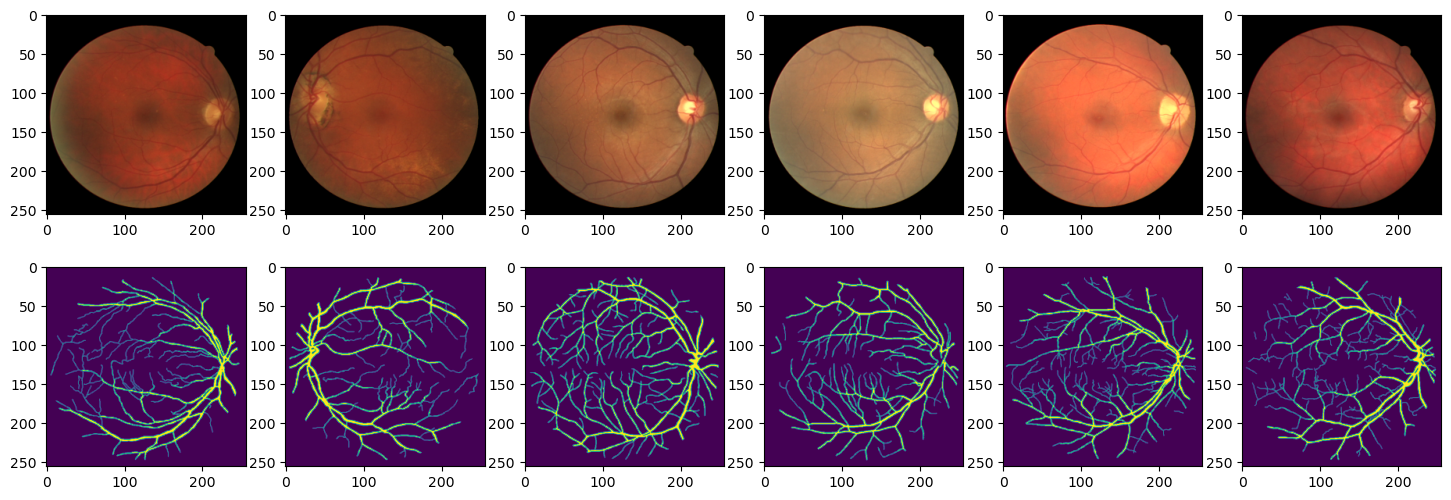

In [35]:
plt.rcParams['figure.figsize'] = [18, 6]

images, labels = next(iter(train_loader))

for i in range(6):
    plt.subplot(2, 6, i+1)
    plt.imshow(np.swapaxes(np.swapaxes(images[i], 0, 2), 0, 1))

    plt.subplot(2, 6, i+7)
    plt.imshow(labels[i].squeeze())
plt.show()

In [36]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


In [37]:
parameters = 256

class EncDec(nn.Module):
    def __init__(self):
        super().__init__()

        # encoder (downsampling)
        self.enc_conv0 = nn.Conv2d(3, parameters, 3, padding=1)
        self.pool0 = nn.MaxPool2d(2, 2)  # 128 -> 64
        self.enc_conv1 = nn.Conv2d(parameters, parameters, 3, padding=1)
        self.pool1 = nn.MaxPool2d(2, 2)  # 64 -> 32
        self.enc_conv2 = nn.Conv2d(parameters, parameters, 3, padding=1)
        self.pool2 = nn.MaxPool2d(2, 2)  # 32 -> 16
        self.enc_conv3 = nn.Conv2d(parameters, parameters, 3, padding=1)
        self.pool3 = nn.MaxPool2d(2, 2)  # 16 -> 8

        # bottleneck
        self.bottleneck_conv = nn.Conv2d(parameters, parameters, 3, padding=1)

        # decoder (upsampling)
        self.upsample0 = nn.Upsample(16)  # 8 -> 16
        self.dec_conv0 = nn.Conv2d(parameters, parameters, 3, padding=1)
        self.upsample1 = nn.Upsample(32)  # 16 -> 32
        self.dec_conv1 = nn.Conv2d(parameters, parameters, 3, padding=1)
        self.upsample2 = nn.Upsample(64)  # 32 -> 64
        self.dec_conv2 = nn.Conv2d(parameters, parameters, 3, padding=1)
        self.upsample3 = nn.Upsample(128)  # 64 -> 128
        self.dec_conv3 = nn.Conv2d(parameters, 1, 3, padding=1)

    def forward(self, x):
        # encoder
        e0 = self.pool0(F.relu(self.enc_conv0(x)))
        e1 = self.pool1(F.relu(self.enc_conv1(e0)))
        e2 = self.pool2(F.relu(self.enc_conv2(e1)))
        e3 = self.pool3(F.relu(self.enc_conv3(e2)))

        # bottleneck
        b = F.relu(self.bottleneck_conv(e3))

        # decoder
        d0 = F.relu(self.dec_conv0(self.upsample0(b)))
        d1 = F.relu(self.dec_conv1(self.upsample1(d0)))
        d2 = F.relu(self.dec_conv2(self.upsample2(d1)))
        d3 = self.dec_conv3(self.upsample3(d2))  # no activation
        return d3

In [38]:
def bce_loss(y_real, y_pred):
    return torch.mean(y_pred - y_real*y_pred + torch.log(1 + torch.exp(-y_pred)))

In [39]:
# Training with Validation

def dice_loss(y_real, y_pred, epsilon=1e-6):
    y_pred = torch.sigmoid(y_pred)
    y_real = y_real.float()
    y_real_flat = y_real.view(y_real.size(0), -1)
    y_pred_flat = y_pred.view(y_pred.size(0), -1)
    intersection = (y_real_flat * y_pred_flat).sum(dim=1)
    union = y_real_flat.sum(dim=1) + y_pred_flat.sum(dim=1)
    dice_coeff = (2. * intersection + epsilon) / (union + epsilon)
    return 1. - dice_coeff.mean()

def intersection_over_union(y_true, y_pred, smooth=1e-6):
    y_true_f = y_true.view(-1)
    y_pred_f = y_pred.view(-1)
    intersection = (y_true_f * y_pred_f).sum()
    union = y_true_f.sum() + y_pred_f.sum() - intersection
    return intersection / (union + smooth)

def accuracy(y_true, y_pred):
    y_pred = y_pred.round()
    correct = (y_true == y_pred).float()
    return correct.sum() / correct.numel()

def sensitivity(y_true, y_pred, epsilon=1e-6):
    y_pred = y_pred.round()
    true_positives = (y_true * y_pred).sum()
    possible_positives = y_true.sum()
    return true_positives / (possible_positives + epsilon)

def specificity(y_true, y_pred, epsilon=1e-6):
    y_pred = y_pred.round()
    true_negatives = ((1 - y_true) * (1 - y_pred)).sum()
    possible_negatives = (1 - y_true).sum()
    return true_negatives / (possible_negatives + epsilon)

def compute_metrics(y_true, y_pred):
    return {
        'Dice': 1 - dice_loss(y_true, y_pred).item(),
        'IoU': intersection_over_union(y_true, y_pred).item(),
        'Accuracy': accuracy(y_true, y_pred).item(),
        'Sensitivity': sensitivity(y_true, y_pred).item(),
        'Specificity': specificity(y_true, y_pred).item()
    }


In [40]:
def train_with_validation(model, optimizer, loss_fn, epochs, train_loader, val_loader):
    for epoch in range(epochs):
        model.train()
        avg_train_loss = 0
        for X_batch, Y_batch in train_loader:
            X_batch, Y_batch = X_batch.to(device), Y_batch.to(device)
            optimizer.zero_grad()
            Y_pred = model(X_batch)
            loss = loss_fn(Y_batch, Y_pred)
            loss.backward()
            optimizer.step()
            avg_train_loss += loss.item() / len(train_loader)
        
        model.eval()
        avg_val_loss = 0
        metrics = {'Dice': 0, 'IoU': 0, 'Accuracy': 0, 'Sensitivity': 0, 'Specificity': 0}
        with torch.no_grad():
            for X_val, Y_val in val_loader:
                X_val, Y_val = X_val.to(device), Y_val.to(device)
                Y_val_pred = model(X_val)
                val_loss = loss_fn(Y_val, Y_val_pred)
                avg_val_loss += val_loss.item() / len(val_loader)
                batch_metrics = compute_metrics(Y_val, Y_val_pred)
                for key in metrics:
                    metrics[key] += batch_metrics[key] / len(val_loader)
        
        print(f"Epoch [{epoch+1}/{epochs}] - Train Loss: {avg_train_loss:.4f}, Val Loss: {avg_val_loss:.4f}")
        for key, value in metrics.items():
            print(f"  {key}: {value:.4f}")
        
        # Plot the output images
        X_test, Y_test = next(iter(train_loader))
        X_test, Y_test = X_test.to(device), Y_test.to(device)
        model.eval()
        with torch.no_grad():
            Y_hat = torch.sigmoid(model(X_test))
            Y_hat = Y_hat.detach().cpu()
        clear_output(wait=True)
        for k in range(6):
            plt.subplot(3, 6, k + 1)
            plt.imshow(X_test[k].cpu().numpy().transpose(1, 2, 0), cmap='gray')
            plt.title('Input')
            plt.axis('off')
            plt.subplot(3, 6, k + 7)
            plt.imshow(Y_hat[k, 0], cmap='gray')
            plt.title('Prediction')
            plt.axis('off')
            plt.subplot(3, 6, k + 13)
            plt.imshow(Y_test[k, 0].cpu(), cmap='gray')
            plt.title('Ground Truth')
            plt.axis('off')
        plt.suptitle(f'Epoch {epoch+1}/{epochs}')
        plt.show()

In [41]:
def predict(model, data):
    model.eval()  # testing mode
    Y_pred = [torch.sigmoid(model(X_batch.to(device))) for X_batch, _ in data]
    return np.array(Y_pred)

In [42]:
model = EncDec().to(device)
summary(model, (3, 256, 256))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1        [-1, 256, 256, 256]           7,168
         MaxPool2d-2        [-1, 256, 128, 128]               0
            Conv2d-3        [-1, 256, 128, 128]         590,080
         MaxPool2d-4          [-1, 256, 64, 64]               0
            Conv2d-5          [-1, 256, 64, 64]         590,080
         MaxPool2d-6          [-1, 256, 32, 32]               0
            Conv2d-7          [-1, 256, 32, 32]         590,080
         MaxPool2d-8          [-1, 256, 16, 16]               0
            Conv2d-9          [-1, 256, 16, 16]         590,080
         Upsample-10          [-1, 256, 16, 16]               0
           Conv2d-11          [-1, 256, 16, 16]         590,080
         Upsample-12          [-1, 256, 32, 32]               0
           Conv2d-13          [-1, 256, 32, 32]         590,080
         Upsample-14          [-1, 256,

### BINARY CROSS ENTROPY

In [43]:
train_with_validation(model, optim.Adam(model.parameters()), bce_loss, 20, train_loader, test_loader)

RuntimeError: The size of tensor a (256) must match the size of tensor b (128) at non-singleton dimension 3

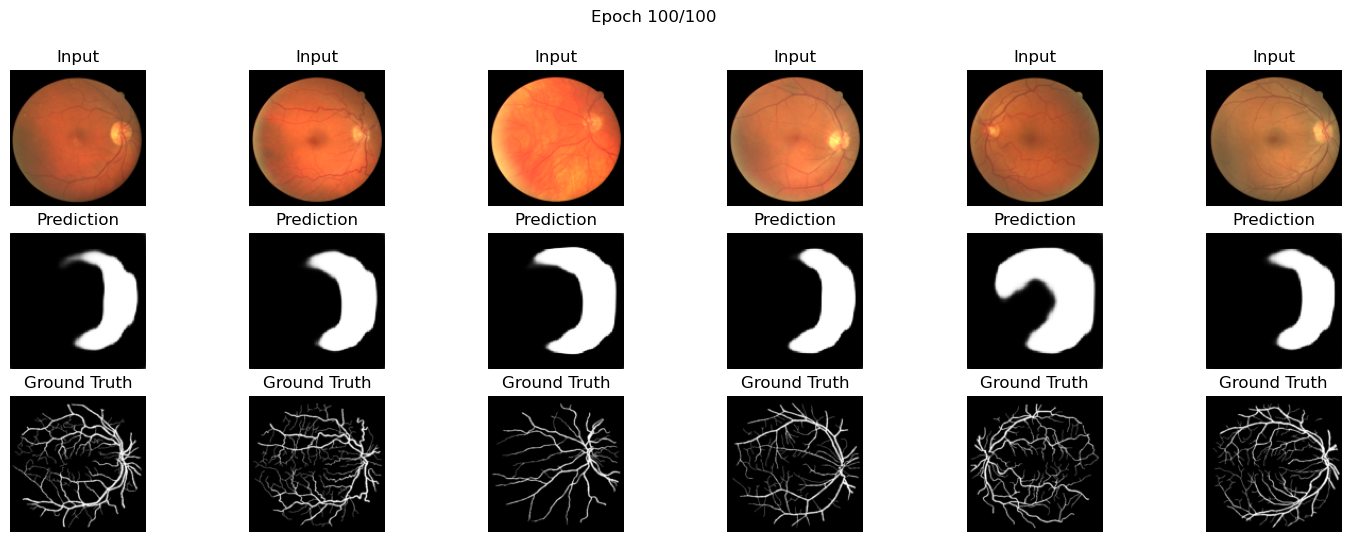

In [33]:
def dice_loss(y_real, y_pred, epsilon=1e-6):
    y_pred = torch.sigmoid(y_pred)
    y_real = y_real.float()
    
    # Flatten spatial dimensions (keep batch dimension)
    y_real_flat = y_real.view(y_real.size(0), -1)
    y_pred_flat = y_pred.view(y_pred.size(0), -1)
    
    # Compute per-sample Dice coefficient
    intersection = (y_real_flat * y_pred_flat).sum(dim=1)
    union = y_real_flat.sum(dim=1) + y_pred_flat.sum(dim=1)
    dice_coeff = (2. * intersection + epsilon) / (union + epsilon)
    
    # Compute Dice loss
    dice_loss = 1. - dice_coeff
    return dice_loss.mean()

model = EncDec().to(device)
train_with_validation(model, optim.Adam(model.parameters(), 0.0001, weight_decay=0.001), dice_loss, 100, train_loader, test_loader)